# Sentiment classification

## Preparation

#### Load libraries

In [3]:
# connect to google drive for importing the finbert model 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

import random

from collections import Counter

# tf-idf
from sklearn.feature_extraction.text import TfidfTransformer    
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pylab as plt 

from tqdm import tqdm

In [5]:
#hyperparameters
seed = 2
batch_size = 16 # [modify]
learning_rate = 2e-5
weight_decay = 1e-2
epsilon = 1e-8
 
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#### Load Annual Report dataset

In [6]:
data = pd.read_excel('/content/annual_report.xlsx')
#train on annual report

In [7]:
data['Final'].value_counts() 

1.0     6487
0.0     4127
10.0    2218
2.0     1309
41.0     336
3.0      275
43.0     160
42.0      82
40.0      16
Name: Final, dtype: int64

In [8]:

data = data[['Sentence','Final']].dropna(how = 'any')

# keep 0, 1, 2 only

filt = data['Final'] <= 2
data = data.loc[filt]

data = data.drop_duplicates()

data

,Sentence,Final
0,2010 年宏观经济环境良好，公司抓住市场机遇，积极开拓市场，不断扩大生产 和销售规模，同时...,1.0
1,2010 年公司股票公开发行，并于 9 月 15 日在深圳证券交易所中小板成功上市。,0.0
2,公司股票上市后，为公司发展创造了良好条件，对公司形象拓展、品牌提升、规范运 作等方面起到了积...,1.0
3,经营范围:生产经营连接线、连接器、电脑周边设备、塑胶五金制品。,0.0
4,公司的电脑连接器产品销售收入占销售收入的主要部分，主要包括台式电脑连接 器和笔记本电脑连接器...,0.0
...,...,...
15005,信息科技投入主要投向 系统运营、电子设备和软件采购、信息科技人力资源配置、信息科技咨询和基础...,0.0
15006,"截至报告期 末，全行累计立项金融科技创新项目2,106个，其中1,374个项目已投产上线，覆...",0.0
15007,随着数字化转型的深入，全行管理能力和效率逐步提升。,1.0
15008,零售金融持续优化客户关系管理系统——W+平台，实 时提供专业建议、上线智能辅助销售功能，线上...,0.0


###Load Analyst Report dataset

In [9]:
# cross-test on analyst report
report = pd.read_excel('/content/analyst_report.xlsx')
report['Final'].value_counts() 

1     5590
0     2916
2     1543
10    1083
3      331
43     220
41     209
42      72
40      35
4        1
Name: Final, dtype: int64

In [10]:
report = report[['Sentence','Final']].dropna(how = 'any')

# # keep 0, 1, 2 only

filt = report['Final'] <= 2
report = report.loc[filt]

report = report.drop_duplicates()

report

,Sentence,Final
0,因2Q收入低于预期，下调19/20年收入预测5.4%/7.1%至56.8/61.2亿元，因成...,2
2,下调A/H股目标价46.4%/52%至7.5元/6.5港元。,0
3,公司Q3继续控制普五发货节奏，批价保持在820元左右。,0
4,船体可以装载长50米、高4.85米、宽8米、重量巨大的特种车辆。,0
5,房地产业务毛利率提升公司上半年房地产业务实现销售收入5.03亿元，同比去年下降-15.46%。,2
...,...,...
11994,今年上半年公司天然气与管道业务实现经营收益139.34亿元，同比增长21.9%。,1
11995,国家管网集团“十四五期间”初步规划新建油气管道超过2.5万公里，LNG接收站、储气库、海上平...,1
11996,行业需求不及预期、市场竞争风险加剧、技术研发不及预期。,2
11997,业务主要分布在华东地区，全国布局雏形初现。,0


## Benchmark methods

#### Clean text


In [11]:
import re
 
def clear_character(sentence):
    pattern1='[a-zA-Z0-9]'
    pattern2 = re.compile(u'[^\s1234567890:：' + '\u4e00-\u9fa5]+')
    pattern3='[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
    line1 = re.sub(pattern1,'',sentence)   #Remove letters and numbers
    line2 = re.sub(pattern2,'',line1)   #remove other characters and emojis
    line3 = re.sub(pattern3,'',line2)   
    new_sentence=''.join(line3.split()) #remove the blank
    return new_sentence

data['Sentence1'] = data['Sentence'].apply(clear_character)
report['Sentence1'] = report['Sentence'].apply(clear_character)
 
data.sample(5)

,Sentence,Final,Sentence1
11095,加快走出去步伐，整合海外销售资源,1.0,加快走出去步伐整合海外销售资源
11588,2017 年，全球全面进入数字经济时代，新一代信息技术与实体经济深度融合，互联网将给各 行各...,1.0,年全球全面进入数字经济时代新一代信息技术与实体经济深度融合互联网将给各行各业赋能带来至大无外...
1148,业务布局取得突破，市场开拓进步明显，报告期内实现营收约13.28亿元，同比增长约61.72%。,1.0,业务布局取得突破市场开拓进步明显报告期内实现营收约亿元同比增长约
1201,此外，公司高度重视在底层材料及创新生产技术的长期耕耘，研发团队持续深入技术前端，学习探索先进...,1.0,此外公司高度重视在底层材料及创新生产技术的长期耕耘研发团队持续深入技术前端学习探索先进精密制...
10686,"本公司2009年 度按香港财务报告准则计算出来的经审计净利润为人民币721,736千元,加上...",0.0,本公司年度按香港财务报告准则计算出来的经审计净利润为人民币千元加上年初未分配利润人民币千元则...


#### Tokenization


In [12]:
import jieba

def sentence_cut(sentence):
    seg = list(jieba.cut(sentence.strip()))
    return seg

tqdm.pandas(desc='apply')
data['Sentence2'] = data['Sentence1'].progress_apply(sentence_cut)
report['Sentence2'] = report['Sentence1'].progress_apply(sentence_cut)

apply:   0%|          | 0/11927 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.037 seconds.
Prefix dict has been built successfully.
apply: 100%|██████████| 10028/10028 [00:02<00:00, 4410.16it/s]


In [13]:
with open('/content/cn_stopwords.txt', 'r', encoding='utf-8') as f:
    stopWords = f.read().split('\n')

stopWords[:30]

['$',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '?',
 '_',
 '“',
 '”',
 '、',
 '。',
 '《',
 '》',
 '一',
 '一些',
 '一何',
 '一切',
 '一则',
 '一方面',
 '一旦',
 '一来',
 '一样',
 '一般',
 '一转眼']

In [14]:
# remove the stopwords

def rm_stop_word(wordList):
    filtered_words = [word for word in wordList if word not in stopWords]
    return filtered_words

data['Sentence3'] = data['Sentence2'].progress_apply(rm_stop_word)
report['Sentence3'] = report['Sentence2'].progress_apply(rm_stop_word)


apply: 100%|██████████| 10028/10028 [00:03<00:00, 2817.88it/s]


In [15]:
# remove words with frequency less than 10

list_set = []
 
for i in range(len(data)):
    for j in data.iloc[i]['Sentence3']: 
        list_set.append(j) # change "extend" into "append"

words_count = Counter(list_set)
min_threshold = 10
my_dict = {k: v for k, v in words_count.items() if v < min_threshold}
filteredA = Counter(my_dict)


def rm_low_frequence_word(wordList):
    
    filtered_words = [word for word in wordList if word not in filteredA]
    return filtered_words

data['Sentence4'] = data['Sentence3'].progress_apply(rm_low_frequence_word)
report['Sentence4'] = report['Sentence3'].progress_apply(rm_low_frequence_word)
data.sample(5)

apply: 100%|██████████| 10028/10028 [00:00<00:00, 138804.76it/s]


,Sentence,Final,Sentence1,Sentence2,Sentence3,Sentence4
11512,"2017 年，公司 4G 用户净增 7033 万户，总数达到 17,488 万户，4G 用户...",1.0,年公司用户净增万户总数达到万户用户市场份额同比提高个百分点用户占移动出账用户比例达到同比提高...,"[年, 公司, 用户, 净增, 万户, 总数, 达到, 万户, 用户, 市场份额, 同比, ...","[年, 公司, 用户, 净增, 万户, 总数, 达到, 万户, 用户, 市场份额, 同比, ...","[年, 公司, 用户, 万户, 总数, 达到, 万户, 用户, 市场份额, 同比, 提高, ..."
13292,积极应对电力体制改革，充分发挥产业链一体化、大容量机组和电源布局优势，优化交易电资源配置。,1.0,积极应对电力体制改革充分发挥产业链一体化大容量机组和电源布局优势优化交易电资源配置,"[积极, 应对, 电力, 体制改革, 充分发挥, 产业链, 一体化, 大容量, 机组, 和,...","[积极, 应对, 电力, 体制改革, 充分发挥, 产业链, 一体化, 大容量, 机组, 电源...","[积极, 应对, 电力, 体制改革, 充分发挥, 产业链, 一体化, 大容量, 机组, 电源..."
5495,公司整体经营目标顺利完成，盈利能力稳固提升，\n自有资金、渠道库存等各项指标持续向好，产品品...,1.0,公司整体经营目标顺利完成盈利能力稳固提升自有资金渠道库存等各项指标持续向好产品品质与口碑持续...,"[公司, 整体, 经营, 目标, 顺利完成, 盈利, 能力, 稳固, 提升, 自有, 资金,...","[公司, 整体, 经营, 目标, 顺利完成, 盈利, 能力, 稳固, 提升, 自有, 资金,...","[公司, 整体, 经营, 目标, 顺利完成, 盈利, 能力, 稳固, 提升, 自有, 资金,..."
11334,新的一年是公司全面实施聚焦战略、创新合作发展的起步之年,1.0,新的一年是公司全面实施聚焦战略创新合作发展的起步之年,"[新, 的, 一年, 是, 公司, 全面实施, 聚焦, 战略, 创新, 合作, 发展, 的,...","[新, 一年, 公司, 全面实施, 聚焦, 战略, 创新, 合作, 发展, 起步, 年]","[新, 一年, 公司, 聚焦, 战略, 创新, 合作, 发展, 年]"
8895,国务院办公厅公布《关于进一步优化营商环境更好服务市场主体的实施意见》，将为龙\n头防水企业做...,1.0,国务院办公厅公布关于进一步优化营商环境更好服务市场主体的实施意见将为龙头防水企业做大做强防水...,"[国务院办公厅, 公布, 关于, 进一步, 优化, 营商, 环境, 更好, 服务, 市场主体...","[国务院办公厅, 公布, 进一步, 优化, 营商, 环境, 更好, 服务, 市场主体, 实施...","[公布, 进一步, 优化, 环境, 更好, 服务, 实施, 意见, 龙头, 防水, 企业, ..."


#### Split into train and test sets

In [16]:
#randomly select 10000 sentences for training
data = data.sample(n=10000)

In [17]:
# Divide the training set and the test set

from sklearn.model_selection import train_test_split

X = data['Sentence4']
y = data['Final']
x_report = report['Sentence4']
y_report = report['Final']

sentence_train, sentence_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
sentence_train, sentence_val, y_train, y_val = train_test_split(sentence_train, y_train, test_size = 0.2, random_state = 2)

print(sentence_train.head(), y_train.head)

10900                             [通信, 技术, 领域, 开展, 广泛, 合作]
13432    [剔除, 财务, 公司, 影响, 集团, 经营, 活动, 现金, 净流入, 同比, 下降, ...
13918                   [努力, 拓展, 中间业务, 手续费, 佣金, 净收入, 稳步增长]
3681      [受, 上述, 三个, 方面, 影响, 现金, 现金, 等价物, 净, 增加额, 上年, 变动]
7431     [年月日, 公司, 宁波, 实业, 投资, 合伙, 企业, 有限, 合伙, 签订, 股权, ...
Name: Sentence4, dtype: object <bound method NDFrame.head of 10900    0.0
13432    2.0
13918    1.0
3681     2.0
7431     0.0
        ... 
13428    2.0
14194    1.0
12938    0.0
3193     0.0
5235     1.0
Name: Final, Length: 6400, dtype: float64>


#### Vectorize text


In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
 
sentence_train1 = [' '.join(i) for i in sentence_train]
sentence_val1 = [' '.join(i) for i in sentence_val]
sentence_test1 = [' '.join(i) for i in sentence_test]
sentence_report = [' '.join(i) for i in x_report]

print(sentence_train[0:5])
print(sentence_train1[0:5])
 
tfidf2 = TfidfTransformer()
counter = CountVectorizer(analyzer = 'word')
# counts = counter.fit_transform(comments_train1)

tfidf_train = tfidf2.fit_transform(counter.fit_transform(sentence_train1))
tfidf_val = tfidf2.transform(counter.transform(sentence_val1))
tfidf_test = tfidf2.transform(counter.transform(sentence_test1))
tfidf_report = tfidf2.transform(counter.transform(sentence_report))

print(tfidf_train.shape,tfidf_val.shape)

10900                             [通信, 技术, 领域, 开展, 广泛, 合作]
13432    [剔除, 财务, 公司, 影响, 集团, 经营, 活动, 现金, 净流入, 同比, 下降, ...
13918                   [努力, 拓展, 中间业务, 手续费, 佣金, 净收入, 稳步增长]
3681      [受, 上述, 三个, 方面, 影响, 现金, 现金, 等价物, 净, 增加额, 上年, 变动]
7431     [年月日, 公司, 宁波, 实业, 投资, 合伙, 企业, 有限, 合伙, 签订, 股权, ...
Name: Sentence4, dtype: object
['通信 技术 领域 开展 广泛 合作', '剔除 财务 公司 影响 集团 经营 活动 现金 净流入 同比 下降 主要 原因 收入 下降 带来 现金 流入 减少', '努力 拓展 中间业务 手续费 佣金 净收入 稳步增长', '受 上述 三个 方面 影响 现金 现金 等价物 净 增加额 上年 变动', '年月日 公司 宁波 实业 投资 合伙 企业 有限 合伙 签订 股权 收购 协议 公司 现金 方式 收购 持有 宁波 股权 交易 定价 确定 亿元 业绩 承诺 公司 标的 公司 子公司 公司 参股 公司 业绩 实现 情况 支付 浮动 业绩 承诺 方向 公司 支付 业绩 补偿 标的 资产 年月日 完成 股权 交割 具体情况 请 详见 公司 年月日 披露 公告']
(6400, 2820) (1600, 2820)


#### Logistic regression

In [19]:
from sklearn.linear_model import LogisticRegression
 
lr_best = LogisticRegression(penalty='l2',solver = 'sag',class_weight = 'balanced')
lr_best.fit(tfidf_train, y_train)
tf_idf_y_pred = lr_best.predict(tfidf_val)

# accuracy: (number of correct predictions)/(total predictions)
acc_logit = metrics.accuracy_score(y_val, tf_idf_y_pred)
print('TF-IDF LR validation accuracy %s' % acc_logit)

f1_micro_logit = metrics.f1_score(y_val, tf_idf_y_pred,average = "micro")
f1_macro_logit = metrics.f1_score(y_val, tf_idf_y_pred,average = "macro")
print('TF-IDF LR validation F1_score %s' % f1_macro_logit)
print('\n')


TF-IDF LR validation accuracy 0.813125
TF-IDF LR validation F1_score 0.7678061241222083




In [20]:
# performance on test set

test_y_pred = lr_best.predict(tfidf_test)

# accuracy: (number of correct predictions)/(total predictions)
test_acc_logit = metrics.accuracy_score(y_test, test_y_pred)
print('TF-IDF LR validation accuracy %s' % test_acc_logit)

f1_micro_logit = metrics.f1_score(y_test, test_y_pred,average = "micro")
f1_macro_logit = metrics.f1_score(y_test, test_y_pred,average = "macro")
print('TF-IDF LR validation F1_score %s' % f1_macro_logit)
print('\n')

TF-IDF LR validation accuracy 0.813
TF-IDF LR validation F1_score 0.7734094729139483




#### Naive Bayes Classifier

In [21]:
from sklearn.naive_bayes import MultinomialNB
# Compute predicted probabilities
nb_model = MultinomialNB(alpha = 0.1,fit_prior = True)
nb_model.fit(tfidf_train, y_train)
probs = nb_model.predict_proba(tfidf_val)

y_pred = []
for i in probs:
  y_pred.append(np.argmax(i))

# Evaluate the classifier
acc_nb = metrics.accuracy_score(y_pred, y_val)
f1_micro_nb = metrics.f1_score(y_pred, y_val, average = 'micro')
f1_macro_nb = metrics.f1_score(y_pred, y_val, average = 'macro')
kappa_nb = metrics.cohen_kappa_score(y_pred, y_val)


print(f'accuracy: {acc_nb*100:.2f}%')
print(f'f1-score: {f1_macro_nb*100:.2f}%')

accuracy: 76.75%
f1-score: 71.74%


In [22]:
# performance on test set

test_probs = nb_model.predict_proba(tfidf_test)
y_pred = []
for i in test_probs:
  y_pred.append(np.argmax(i))

# Evaluate the classifier
acc_nb = metrics.accuracy_score(y_pred, y_test)
f1_micro_nb = metrics.f1_score(y_pred, y_test, average = 'micro')
f1_macro_nb = metrics.f1_score(y_pred, y_test, average = 'macro')
kappa_nb = metrics.cohen_kappa_score(y_pred, y_test)


print(f'accuracy: {acc_nb*100:.2f}%')
print(f'f1-score: {f1_macro_nb*100:.2f}%')

accuracy: 77.95%
f1-score: 72.20%


## Chinese BERT

In [24]:
# list
X = data['Sentence'].tolist() # [modify]

# array
label_list = []
for i in data['Final']:
    label_list.append([i])
y = np.array(label_list) 
total_targets = torch.tensor(y)

#### Set up GPU for training


In [25]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


#### Install the HuggingFace library

#### Tokenization and input formatting

In [26]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 9.2 MB/s 
     |████████████████████████████████| 636 kB 58.3 MB/s 
     |████████████████████████████████| 3.3 MB 48.7 MB/s 
     |████████████████████████████████| 895 kB 23.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [27]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

print(X[2])
print(tokenizer.tokenize(X[2]))
print(tokenizer.encode(X[2]))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode(X[2])))

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

报告期内，公司投资规模增加，投资结构得到优化。
['报', '告', '期', '内', '，', '公', '司', '投', '资', '规', '模', '增', '加', '，', '投', '资', '结', '构', '得', '到', '优', '化', '。']
[101, 2845, 1440, 3309, 1079, 8024, 1062, 1385, 2832, 6598, 6226, 3563, 1872, 1217, 8024, 2832, 6598, 5310, 3354, 2533, 1168, 831, 1265, 511, 102]
['[CLS]', '报', '告', '期', '内', '，', '公', '司', '投', '资', '规', '模', '增', '加', '，', '投', '资', '结', '构', '得', '到', '优', '化', '。', '[SEP]']


In [28]:
# Encode
encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in X]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_sentences])
print('Max length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


Max length:  671


In [29]:
encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in X]

sent_length = []

for sent in encoded_sentences:
  sent_length.append(len(sent))

pd.Series(sent_length).describe(percentiles=[.95])

count    10000.000000
mean        60.384500
std         37.125979
min          6.000000
50%         52.000000
95%        128.000000
max        671.000000
dtype: float64

In [30]:
def convert_text_to_token(tokenizer, sentence, limit_size = 130): # around 95% amoung the length
    
    tokens = tokenizer.encode(sentence[:limit_size])       
    if len(tokens) < limit_size + 2:              #padding
        tokens.extend([0] * (limit_size + 2 - len(tokens)))
    return tokens
 
input_ids = [convert_text_to_token(tokenizer, sen) for sen in X]
 
input_tokens = torch.tensor(input_ids)
print(input_tokens.shape) 
print(input_tokens)

torch.Size([10000, 132])
tensor([[ 101, 6084, 6598,  ...,    0,    0,    0],
        [ 101, 2832, 6598,  ...,    0,    0,    0],
        [ 101, 2845, 1440,  ...,    0,    0,    0],
        ...,
        [ 101, 8285, 2399,  ...,    0,    0,    0],
        [ 101, 2845, 1440,  ...,    0,    0,    0],
        [ 101, 1062, 1385,  ...,    0,    0,    0]])


In [31]:

def attention_masks(input_ids):
    atten_masks = []
    for seq in input_ids:                       
        seq_mask = [float(i > 0) for i in seq]  
        atten_masks.append(seq_mask)
    return atten_masks
 
atten_masks = attention_masks(input_ids)
attention_tokens = torch.tensor(atten_masks)
print(attention_tokens.shape)      
print(attention_tokens)             

torch.Size([10000, 132])
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


In [32]:
from sklearn.model_selection import train_test_split
 
train_inputs1, test_inputs, train_labels, test_labels = train_test_split(input_tokens, total_targets, random_state = 2, test_size = 0.2)
train_masks, test_masks, _, _ = train_test_split(attention_tokens, input_tokens, random_state = 2, test_size = 0.2)

train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs1, train_labels, random_state = 2, test_size = 0.2)
train_masks, val_masks, _, _ = train_test_split(train_masks, train_inputs1, random_state = 2, test_size = 0.2)

print(train_inputs.shape, val_inputs.shape)      
print(train_masks.shape)                          
 

torch.Size([6400, 132]) torch.Size([1600, 132])
torch.Size([6400, 132])


#### Create DataLoader

In [33]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [34]:
for i, (train, mask, label) in enumerate(train_dataloader): 
    print(train.shape, mask.shape, label.shape)
    break

print('len(train_dataloader) = ', len(train_dataloader))

torch.Size([16, 132]) torch.Size([16, 132]) torch.Size([16, 1])
len(train_dataloader) =  400


#### Define useful functions

In [35]:


def binary_acc(preds, labels):
    correct = torch.eq(torch.max(preds, dim=1)[1], labels.flatten()).float()
    acc = correct.sum().item() / len(correct)
    return acc

In [36]:


import time
import datetime
 
def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds = elapsed_rounded)) 

In [37]:
def train(model, optimizer):
    
    t0 = time.time()
    avg_loss, avg_acc, train_logits = [],[],[]

    model.train()
    for step, batch in enumerate(train_dataloader):

        # print every 40 batches
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids, b_input_mask, b_labels = batch[0].long().to(device), batch[1].long().to(device), batch[2].long().to(device)

        output = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask, labels = b_labels)
        loss, logits = output[0], output[1]

        avg_loss.append(loss.item())
        train_logits.append(logits)

        acc = binary_acc(logits, b_labels)
        avg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)      
        optimizer.step()              
        scheduler.step()              

    avg_acc = np.array(avg_acc).mean()
    avg_loss = np.array(avg_loss).mean()
    
    return avg_loss, avg_acc, train_logits

In [38]:
def evaluate(model):
    
    avg_acc, val_logits, val_y = [],[],[]
    model.eval()        

    with torch.no_grad():
        for batch in val_dataloader: 
            b_input_ids, b_input_mask, b_labels = batch[0].long().to(device), batch[1].long().to(device), batch[2].long().to(device)

            val_y.append(b_labels)

            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            val_logits.append(output[0])
            # output[0]: logits

            acc = binary_acc(output[0], b_labels)
            avg_acc.append(acc)

    avg_acc = np.array(avg_acc).mean()
    
    return avg_acc, val_logits, val_y

In [39]:
def prediction(model, test_dataloader):
  test_acc, test_logits, test_y = [],[],[]
  model.eval()       

  with torch.no_grad():
    for batch in test_dataloader: 
        b_input_ids, b_input_mask, b_labels = batch[0].long().to(device), batch[1].long().to(device), batch[2].long().to(device)

        test_y.append(b_labels)

        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        test_logits.append(output[0])

        acc = binary_acc(output[0], b_labels)
        test_acc.append(acc)

    #avg_test_acc = np.array(test_acc).mean()

    pred_list_test = []

    for tensori in test_logits:
      pred_list_test.extend(torch.max(tensori, dim = 1)[1].cpu().numpy().tolist())


    true_list_test = []

    for tensori in test_y:
      true_list_test.extend(tensori.flatten().cpu().numpy().tolist())
    
    test_acc_bert = metrics.accuracy_score(pred_list_test, true_list_test)
    test_f1_micro_bert = metrics.f1_score(pred_list_test, true_list_test, average = 'micro')
    test_f1_macro_bert = metrics.f1_score(pred_list_test, true_list_test, average = 'macro')
    test_kappa_bert = metrics.cohen_kappa_score(pred_list_test, true_list_test)

    print('BERT test accuracy %s' % test_acc_bert)
    print('BERT test F1 score %s' % test_f1_macro_bert)


#### Create model and optimizer

In [40]:
# loading the finbert model
# the pytorch model can be downloaded at https://github.com/valuesimplex/FinBERT

from transformers import BertModel,BertTokenizer

BERT_PATH = '/content/drive/MyDrive/Finbert' # subject to the location

tokenizer = BertTokenizer.from_pretrained(BERT_PATH)


print(tokenizer.tokenize('I have a good time, thank you.'))

model = BertModel.from_pretrained(BERT_PATH)

print('load bert model over')

['i', 'have', 'a', 'good', 'time', ',', 'than', '##k', 'you', '.']


Some weights of the model checkpoint at /content/drive/MyDrive/Finbert were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


load bert model over


In [41]:
# the base bert model, uncomment to use

#model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels = 3) 

#model.to(device)

In [42]:
model = BertForSequenceClassification.from_pretrained(BERT_PATH,  num_labels = 3) 

model.to(device)

Some weights of the model checkpoint at /content/drive/MyDrive/Finbert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [43]:
# the optimizer
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params' : [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                'weight_decay' : weight_decay},
    {'params' : [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                'weight_decay' : 0.0}
]
 
optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate, eps = epsilon)

In [44]:

from transformers import get_linear_schedule_with_warmup

epochs = 5 # [modify]

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

#### Train and evaluate the model  
The logits are the output of the BERT Model before a softmax activation function is applied to the output of BERT.   
After we pass the input encoding into the BERT Model, we can get the logits simply by specifying output.logits, which returns a tensor, and after this we can finally apply a softmax activation function to the logits. 

In [45]:
epochs = 5
train_list = []
val_list = []
loss_list = []
for epoch in range(epochs):

    train_loss, train_acc, train_logits = train(model, optimizer)
    print('epoch = {}, 训练集准确率 = {}, 损失 = {}'.format(epoch, train_acc, train_loss))
    
    val_acc, val_logits, val_y = evaluate(model)
    train_list.append(train_acc)
    val_list.append(val_acc)
    loss_list.append(train_loss)
    print("epoch = {}, 验证集准确率 = {}".format(epoch, val_acc))

  Batch    40  of    400.    Elapsed: 0:00:09.
  Batch    80  of    400.    Elapsed: 0:00:19.
  Batch   120  of    400.    Elapsed: 0:00:28.
  Batch   160  of    400.    Elapsed: 0:00:37.
  Batch   200  of    400.    Elapsed: 0:00:46.
  Batch   240  of    400.    Elapsed: 0:00:55.
  Batch   280  of    400.    Elapsed: 0:01:04.
  Batch   320  of    400.    Elapsed: 0:01:14.
  Batch   360  of    400.    Elapsed: 0:01:23.
epoch = 0, 训练集准确率 = 0.8759375, 损失 = 0.33922225879505274
epoch = 0, 验证集准确率 = 0.89
  Batch    40  of    400.    Elapsed: 0:00:09.
  Batch    80  of    400.    Elapsed: 0:00:18.
  Batch   120  of    400.    Elapsed: 0:00:27.
  Batch   160  of    400.    Elapsed: 0:00:37.
  Batch   200  of    400.    Elapsed: 0:00:46.
  Batch   240  of    400.    Elapsed: 0:00:55.
  Batch   280  of    400.    Elapsed: 0:01:04.
  Batch   320  of    400.    Elapsed: 0:01:13.
  Batch   360  of    400.    Elapsed: 0:01:22.
epoch = 1, 训练集准确率 = 0.93921875, 损失 = 0.1824243660841603
epoch = 1, 验证集准确率

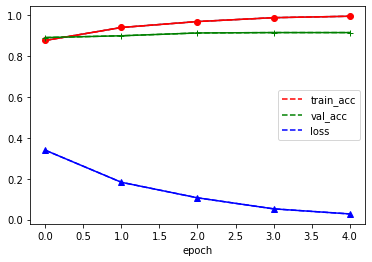

In [46]:
import matplotlib.pyplot as plt 
x=np.arange(0,5)
plt.plot(x,train_list)

l1=plt.plot(x,train_list,'r--',label='train_acc')
l2=plt.plot(x,val_list,'g--',label='val_acc')
l3=plt.plot(x,loss_list,'b--',label='loss')
plt.plot(x,train_list,'ro-',x,val_list,'g+-',x,loss_list,'b^-')
plt.xlabel('epoch')
plt.legend()
plt.show()


In [47]:
pred_list = []

for tensori in val_logits:
  pred_list.extend(torch.max(tensori, dim = 1)[1].cpu().numpy().tolist())

# pred_list

true_list = []

for tensori in val_y:
  true_list.extend(tensori.flatten().cpu().numpy().tolist())

# true_list

In [48]:
acc_bert = metrics.accuracy_score(pred_list, true_list)
f1_micro_bert = metrics.f1_score(pred_list, true_list, average = 'micro')
f1_macro_bert = metrics.f1_score(pred_list, true_list, average = 'macro')
kappa_bert = metrics.cohen_kappa_score(pred_list, true_list)

print('BERT validation accuracy %s' % acc_bert)
print('BERT validation F1 score %s' % f1_macro_bert)

BERT validation accuracy 0.914375
BERT validation F1 score 0.8990432556819502


In [49]:
# probabilities

import torch.nn.functional as F

val_logits2 = torch.cat(val_logits, dim = 0)

probs = F.softmax(val_logits2, dim = 1).cpu().detach().numpy()

probs
# You can't call .numpy() on a tensor if that tensor is part of the computation graph. 
# You first have to detach it from the graph and this will return a new tensor that shares the same underlying storage 
# but doesn't track gradients (requires_grad is False). Then you can call .numpy() safely. 
# So just replace tensor.numpy() with tensor.detach().numpy().

array([[9.9941981e-01, 3.1788976e-04, 2.6234126e-04],
       [3.5065407e-04, 9.9946851e-01, 1.8084525e-04],
       [9.9951637e-01, 2.8987572e-04, 1.9377866e-04],
       ...,
       [9.9917680e-01, 5.6224869e-04, 2.6100044e-04],
       [3.8195294e-04, 9.9944931e-01, 1.6876076e-04],
       [9.3632267e-04, 9.9853849e-01, 5.2519236e-04]], dtype=float32)

### Prediction on test set

In [50]:
prediction(model,test_dataloader)

BERT test accuracy 0.9085
BERT test F1 score 0.8817399560187017


## Evaluate on other data




In [51]:
report = pd.read_excel('/content/analyst_report.xlsx')

In [52]:
report['Final'].value_counts() 

1     5590
0     2916
2     1543
10    1083
3      331
43     220
41     209
42      72
40      35
4        1
Name: Final, dtype: int64

In [53]:

report = report[['Sentence','Final']].dropna(how = 'any')

filt = report['Final'] <= 2
report = report.loc[filt]

report = report.drop_duplicates()

report

,Sentence,Final
0,因2Q收入低于预期，下调19/20年收入预测5.4%/7.1%至56.8/61.2亿元，因成...,2
2,下调A/H股目标价46.4%/52%至7.5元/6.5港元。,0
3,公司Q3继续控制普五发货节奏，批价保持在820元左右。,0
4,船体可以装载长50米、高4.85米、宽8米、重量巨大的特种车辆。,0
5,房地产业务毛利率提升公司上半年房地产业务实现销售收入5.03亿元，同比去年下降-15.46%。,2
...,...,...
11994,今年上半年公司天然气与管道业务实现经营收益139.34亿元，同比增长21.9%。,1
11995,国家管网集团“十四五期间”初步规划新建油气管道超过2.5万公里，LNG接收站、储气库、海上平...,1
11996,行业需求不及预期、市场竞争风险加剧、技术研发不及预期。,2
11997,业务主要分布在华东地区，全国布局雏形初现。,0


In [54]:
report['Final'].value_counts() 

1    5581
0    2907
2    1540
Name: Final, dtype: int64

### Bert

In [55]:
def data_prepration(data):
  # list
  X = data['Sentence'].tolist() # [modify]

  # array
  label_list = []
  for i in data['Final']:
      label_list.append([i])
  y = np.array(label_list) 
  total_targets = torch.tensor(y)

  input_ids = [convert_text_to_token(tokenizer, sen) for sen in X]
  input_tokens = torch.tensor(input_ids)


  atten_masks = attention_masks(input_ids)
  attention_tokens = torch.tensor(atten_masks)
  print(attention_tokens.shape)      
  print(attention_tokens) 

  test_data = TensorDataset(input_tokens, attention_tokens, total_targets)
  test_sampler = RandomSampler(test_data)
  test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

  return test_dataloader


In [56]:
report_dataloader = data_prepration(report)

torch.Size([10028, 132])
tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])


In [ ]:
prediction(model,report_dataloader)

In [ ]:
test_acc, test_logits, test_y = [],[],[]
output_list = []
model.eval()       

with torch.no_grad():
  for batch in report_dataloader: 
      b_input_ids, b_input_mask, b_labels = batch[0].long().to(device), batch[1].long().to(device), batch[2].long().to(device)

      test_y.append(b_labels)

      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

      test_logits.append(output[0])
      # output[0]: logits

      acc = binary_acc(output[0], b_labels)
      test_acc.append(acc)

  avg_test_acc = np.array(test_acc).mean()

  pred_list_test = []

  for tensori in test_logits:
    pred_list_test.extend(torch.max(tensori, dim = 1)[1].cpu().numpy().tolist())

  # pred_list

  true_list_test = []

  for tensori in test_y:
    true_list_test.extend(tensori.flatten().cpu().numpy().tolist())
  
  test_acc_bert = metrics.accuracy_score(pred_list_test, true_list_test)
  test_f1_micro_bert = metrics.f1_score(pred_list_test, true_list_test, average = 'micro')
  test_f1_macro_bert = metrics.f1_score(pred_list_test, true_list_test, average = 'macro')
  test_kappa_bert = metrics.cohen_kappa_score(pred_list_test, true_list_test)

  print('BERT test accuracy %s' % test_acc_bert)
  print('BERT test F1 score %s' % test_f1_macro_bert)

In [ ]:
bt_pred_list_test = Counter(pred_list_test)
print(bt_pred_list_test)

### Logistic Regression

In [ ]:
report_y_pred = lr_best.predict(tfidf_report)

# accuracy: (number of correct predictions)/(total predictions)
report_acc_logit = metrics.accuracy_score(y_report, report_y_pred)
print('TF-IDF LR validation accuracy %s' % report_acc_logit)

f1_micro_logit = metrics.f1_score(y_report, report_y_pred,average = "micro")
f1_macro_logit = metrics.f1_score(y_report, report_y_pred,average = "macro")
print('TF-IDF LR validation F1_score %s' % f1_macro_logit)
print('\n')

In [ ]:
lr_pred_count = Counter(report_y_pred)
lr_pred_count

### Naive Bayes Classifier

In [62]:
test_probs = nb_model.predict_proba(tfidf_report)
y_pred = []
for i in test_probs:
  y_pred.append(np.argmax(i))

# Evaluate the classifier
acc_nb = metrics.accuracy_score(y_pred, y_report)
f1_micro_nb = metrics.f1_score(y_pred, y_report, average = 'micro')
f1_macro_nb = metrics.f1_score(y_pred, y_report, average = 'macro')
kappa_nb = metrics.cohen_kappa_score(y_pred, y_report)


print(f'accuracy: {acc_nb*100:.2f}%')
print(f'f1-score: {f1_macro_nb*100:.2f}%')

accuracy: 66.84%
f1-score: 62.52%


In [ ]:
from collections import Counter
pred_count = Counter(y_pred)
true_count = Counter(y_report)
print(pred_count)
print(true_count) 

## Save the model

In [78]:
# save the whole model
torch.save(model,'/content/bert.pth.tar')
# the model can be downloaded at: https://drive.google.com/file/d/1_lzotgExsv2AjhktxnJsJEP6KdhKc6IE/view?usp=sharing